# Concevez une application au service de la santé publique (Analyse)

The "Public Health France" agency has launched a call for projects to find innovative ideas for food-related applications. You wish to participate and propose an application idea.

The Open Food Fact dataset is available on the official website. The variables are defined at this address.

The dataset has as datapoint each product (1443749 products) and for each couple we have 181 columns which are separated in four sections :

- General information on the product datasheet: name, date of modification, etc.
- A set of tags: product category, location, origin, etc.
- The ingredients that make up the products and their possible additives.
- Nutritional information: quantity in grams of a nutrient per 100 grams of the product.
- The goal of the project is to understand this dataset, to draw some insights and finally to train a model able to predict the nutriscore for each product in the way of the Yuka application.

How is the nutriscore awarded?

The score takes into account for 100 grams of product, the content :

- Nutrients and foods to be promoted (fibers, proteins, fruits and vegetables),
- Nutrients to be limited (energy, saturated fatty acids, sugars, salt).
- After calculation, the score obtained by a product is used to assign it a letter (A to D) and a color.


In [121]:
import json
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
pd.options.mode.chained_assignment = None

## 1. Data Import

In [35]:
df = pd.read_csv('openfoodfacts_products_cleaned.csv', low_memory=False)

## 2. Data Description
##### Show data header


In [40]:
df.head(3)

,code,product_name,main_category_en,pnns_groups_1,pnns_groups_2,nutriscore_score,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,0000000000017,vitória crackers,NaN,unknown,unknown,NaN,NaN,1569.0,7.0,3.08,70.1,15.0,0.0,7.8,1.40
1,0000000000100,moutarde au moût de raisin,Mustards,Fat and sauces,Dressings and sauces,18.0,d,936.0,8.2,2.20,29.0,22.0,0.0,5.1,4.60
2,0000000000123,sauce sweety chili 0%,NaN,unknown,unknown,NaN,NaN,88.0,0.0,0.00,4.8,0.4,0.0,0.2,2.04


##### Show data info


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045457 entries, 0 to 1045456
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   code                1045457 non-null  object 
 1   product_name        1045455 non-null  object 
 2   main_category_en    593670 non-null   object 
 3   pnns_groups_1       1043571 non-null  object 
 4   pnns_groups_2       1045457 non-null  object 
 5   nutriscore_score    536478 non-null   float64
 6   nutriscore_grade    536478 non-null   object 
 7   energy_100g         1044885 non-null  float64
 8   fat_100g            1042722 non-null  float64
 9   saturated-fat_100g  1014514 non-null  float64
 10  carbohydrates_100g  1042626 non-null  float64
 11  sugars_100g         1036956 non-null  float64
 12  fiber_100g          1045457 non-null  float64
 13  proteins_100g       1044779 non-null  float64
 14  salt_100g           1043815 non-null  float64
dtypes: float64(9), 

##### Fix data types


In [43]:
df.product_name = df.product_name.astype('category')
df.main_category_en = df.main_category_en.astype('category')
df.pnns_groups_1 = df.pnns_groups_1.astype('category')
df.pnns_groups_2 = df.pnns_groups_2.astype('category')
df.nutriscore_grade = df.nutriscore_grade.astype('category')

Now, let's check our new data types and column names:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045457 entries, 0 to 1045456
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   code                1045457 non-null  object  
 1   product_name        1045455 non-null  category
 2   main_category_en    593670 non-null   category
 3   pnns_groups_1       1043571 non-null  category
 4   pnns_groups_2       1045457 non-null  category
 5   nutriscore_score    536478 non-null   float64 
 6   nutriscore_grade    536478 non-null   category
 7   energy_100g         1044885 non-null  float64 
 8   fat_100g            1042722 non-null  float64 
 9   saturated-fat_100g  1014514 non-null  float64 
 10  carbohydrates_100g  1042626 non-null  float64 
 11  sugars_100g         1036956 non-null  float64 
 12  fiber_100g          1045457 non-null  float64 
 13  proteins_100g       1044779 non-null  float64 
 14  salt_100g           1043815 non-null  float64 
dty

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [45]:
df.describe()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,536478.000000,1.044885e+06,1.042722e+06,1.014514e+06,1.042626e+06,1.036956e+06,1.045457e+06,1.044779e+06,1.043815e+06
mean,8.973164,1.095151e+03,1.264644e+01,4.983637e+00,2.742256e+01,1.327794e+01,8.781615e-01,8.500612e+00,1.219405e+00
std,8.908539,7.478307e+02,1.565022e+01,7.302543e+00,2.746102e+01,1.918074e+01,2.549140e+00,9.633584e+00,3.845868e+00
min,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,4.230000e+02,7.000000e-01,1.000000e-01,3.570000e+00,7.000000e-01,0.000000e+00,1.400000e+00,8.000000e-02
50%,10.000000,1.046000e+03,6.700000e+00,1.800000e+00,1.462000e+01,3.700000e+00,0.000000e+00,5.810000e+00,5.750000e-01
75%,16.000000,1.632000e+03,2.000000e+01,7.000000e+00,5.200000e+01,1.846000e+01,1.000000e-01,1.200000e+01,1.392500e+00
max,40.000000,3.700000e+03,9.997000e+01,9.990000e+01,9.999000e+01,1.000000e+02,9.550000e+01,9.990000e+01,9.999000e+01


##### Show if there are missing datapoints¶


In [49]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

code , 0.0
product_name , 0.0
main_category_en , 43.21
pnns_groups_1 , 0.18
pnns_groups_2 , 0.0
nutriscore_score , 48.68
nutriscore_grade , 48.68
energy_100g , 0.05
fat_100g , 0.26
saturated-fat_100g , 2.96
carbohydrates_100g , 0.27
sugars_100g , 0.8099999999999999
fiber_100g , 0.0
proteins_100g , 0.06
salt_100g , 0.16


[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1, 'Missing Data')]

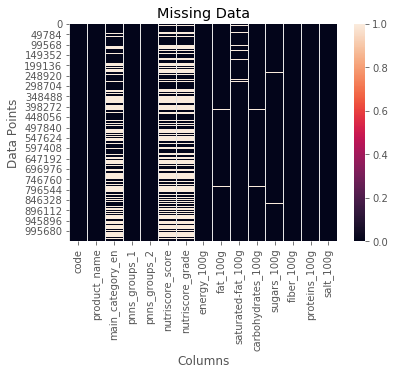

In [59]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the categorical features.

Later in the project we will deal with these missing data points, in the data cleaning section.

In [148]:
df['energy_100g'] = df['energy_100g'].fillna(df.groupby(['pnns_groups_1', 'nutriscore_grade'])['energy_100g'].transform('mean'))

df['fat_100g'] = df['fat_100g'].fillna(df.groupby(['pnns_groups_1', 'nutriscore_grade'])['fat_100g'].transform('mean'))

df['saturated-fat_100g'] = df['saturated-fat_100g'].fillna(df.groupby(['pnns_groups_1', 'nutriscore_grade'])['saturated-fat_100g'].transform('mean'))

df['carbohydrates_100g'] = df['carbohydrates_100g'].fillna(df.groupby(['pnns_groups_1', 'nutriscore_grade'])['carbohydrates_100g'].transform('mean'))

df['sugars_100g'] = df['sugars_100g'].fillna(df.groupby(['pnns_groups_1','nutriscore_grade'])['sugars_100g'].transform('mean'))

df['proteins_100g'] = df['proteins_100g'].fillna(df.groupby(['pnns_groups_1','nutriscore_grade'])['proteins_100g'].transform('mean'))

df['salt_100g'] = df['salt_100g'].fillna(df.groupby(['pnns_groups_1','nutriscore_grade'])['salt_100g'].transform('mean'))



In [149]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

code , 0.0
product_name , 0.0
main_category_en , 43.21
pnns_groups_1 , 0.18
pnns_groups_2 , 0.0
nutriscore_score , 48.68
nutriscore_grade , 48.68
energy_100g , 0.05
fat_100g , 0.0
saturated-fat_100g , 2.96
carbohydrates_100g , 0.25
sugars_100g , 0.8099999999999999
fiber_100g , 0.0
proteins_100g , 0.06
salt_100g , 0.16


## 2. EDA
### 2.1 Univariate Analysis: Numerical Variable

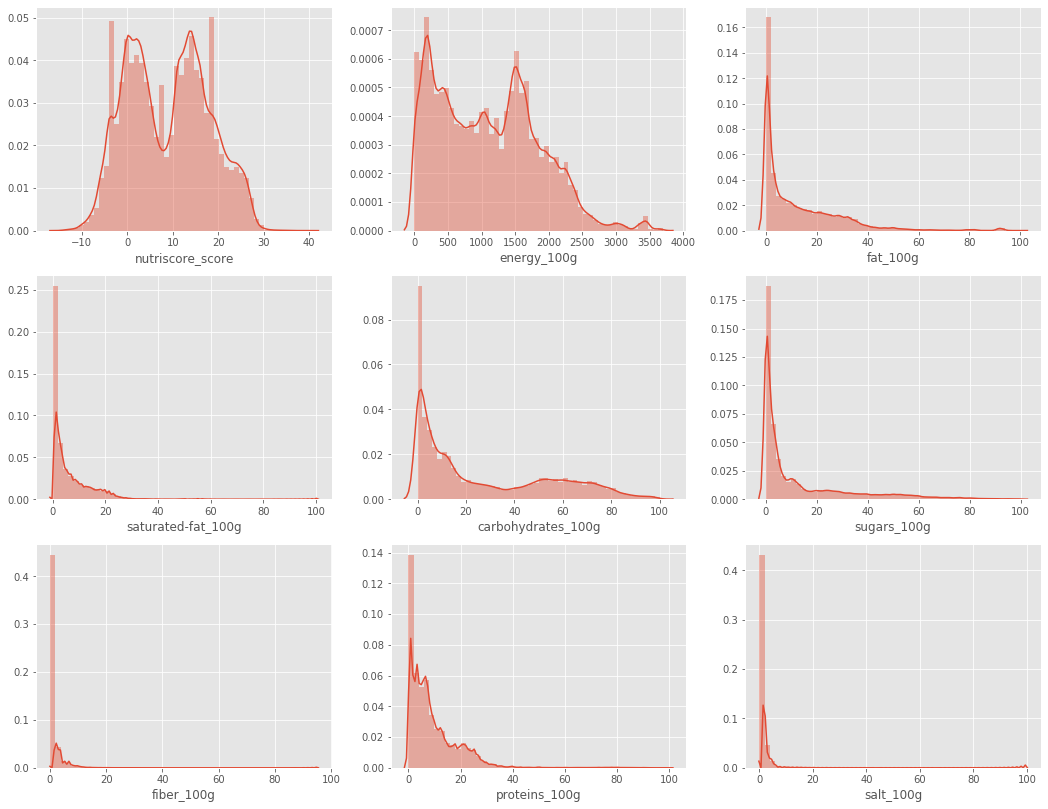

In [78]:


def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ['nutriscore_score', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'])

matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


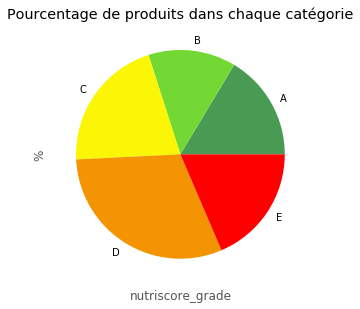

In [85]:
macro_nutriments_labels = []
for col in df :
    if "_100g" in col :
        macro_nutriments_labels.append(col)

colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]
labels = ["A", "B", "C", "D", "E"]
df['nutriscore_grade'].dropna().value_counts(normalize=True).sort_index().plot(kind='pie', colors=colors, labels=labels)
plt.title("Pourcentage de produits dans chaque catégorie")
plt.ylabel("%")
plt.xlabel("nutriscore_grade")
plt.xticks(rotation=0)
plt.style.use('ggplot')
plt.show()

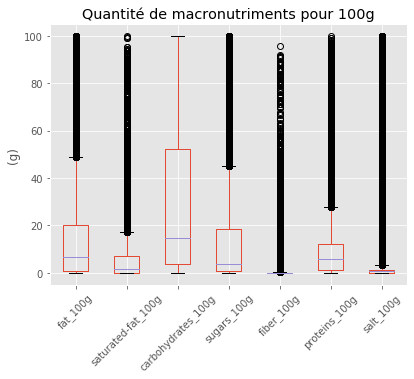

In [83]:
df[macro_nutriments_labels].drop(columns="energy_100g").boxplot()
plt.xticks(rotation=45)
plt.ylabel("(g)")
plt.title("Quantité de macronutriments pour 100g")
plt.style.use('ggplot')
plt.show()

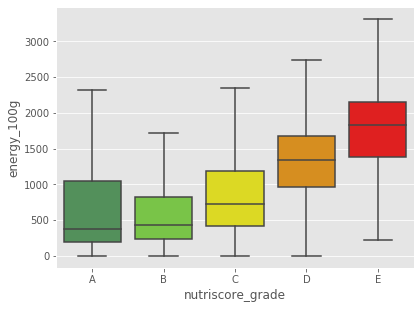

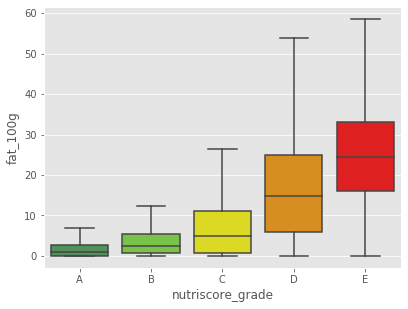

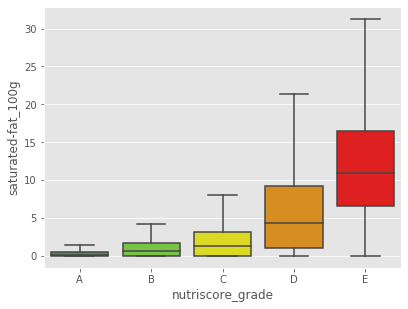

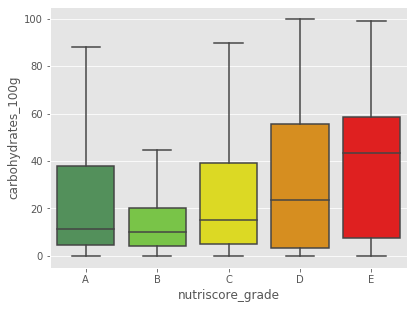

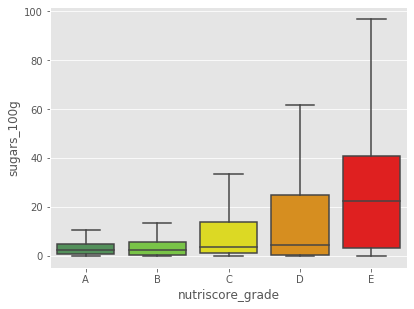

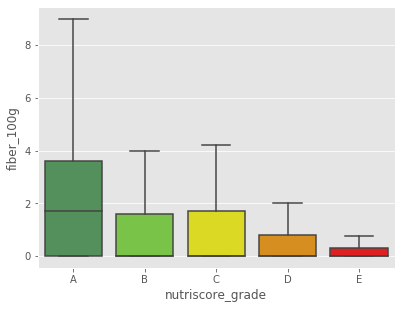

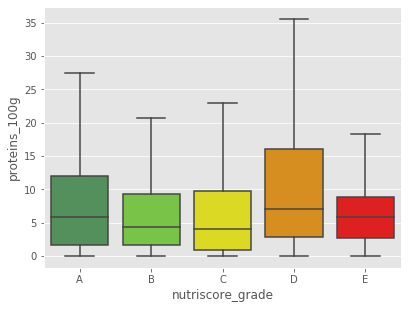

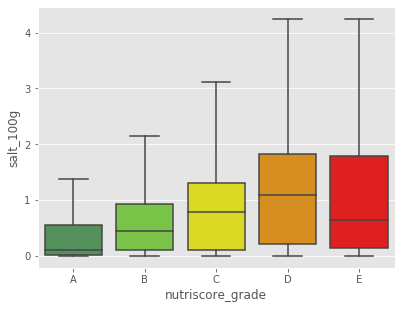

In [84]:
data_for_plot = df[macro_nutriments_labels + ["nutriscore_grade"]].dropna(subset=["nutriscore_grade"])
order = sorted(df["nutriscore_grade"].dropna().unique())
labels = ['A', 'B', 'C', 'D', 'E']
y_pos = np.arange(len(labels))
for macro_nutri in macro_nutriments_labels :
    sns.boxplot(data=data_for_plot, x='nutriscore_grade', y=macro_nutri, order=order, showfliers=False, palette={'a':"#499A53", 'b':"#74D834", 'c':"#FBF605", 'd':"#F49402", 'e':"#FF0000"})
    plt.xticks(y_pos, labels)
    plt.show()


- Plus il y a de sucre, de graisses et de sel dans un produit et plus son Nutri-Score est mauvais
- Plus un aliment est riche en fibre, plus sa probabilité d'être de mauvaise qualité nutritionnelle est faible

### 2.3 Correlation

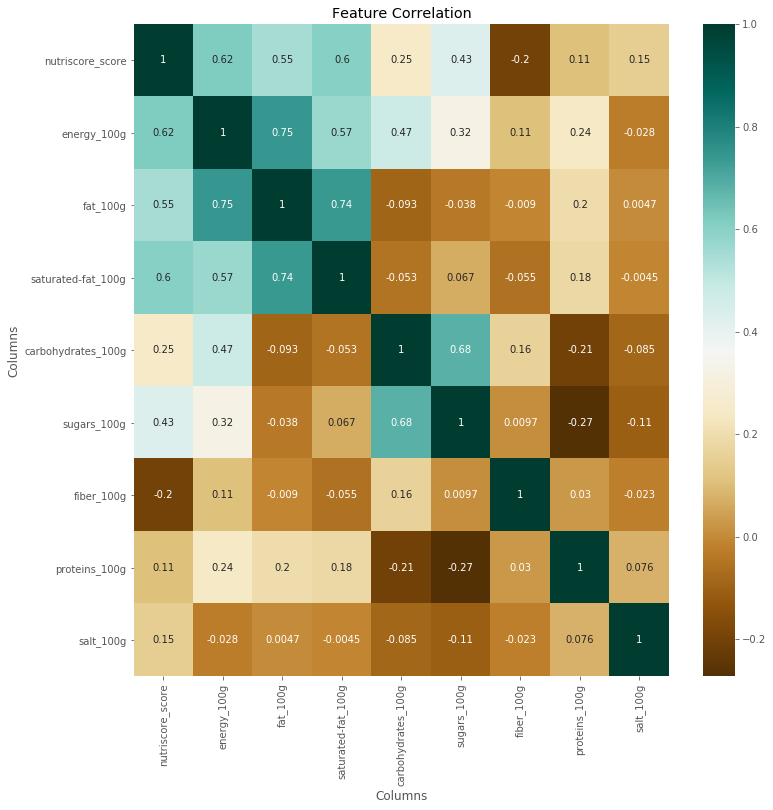

In [88]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

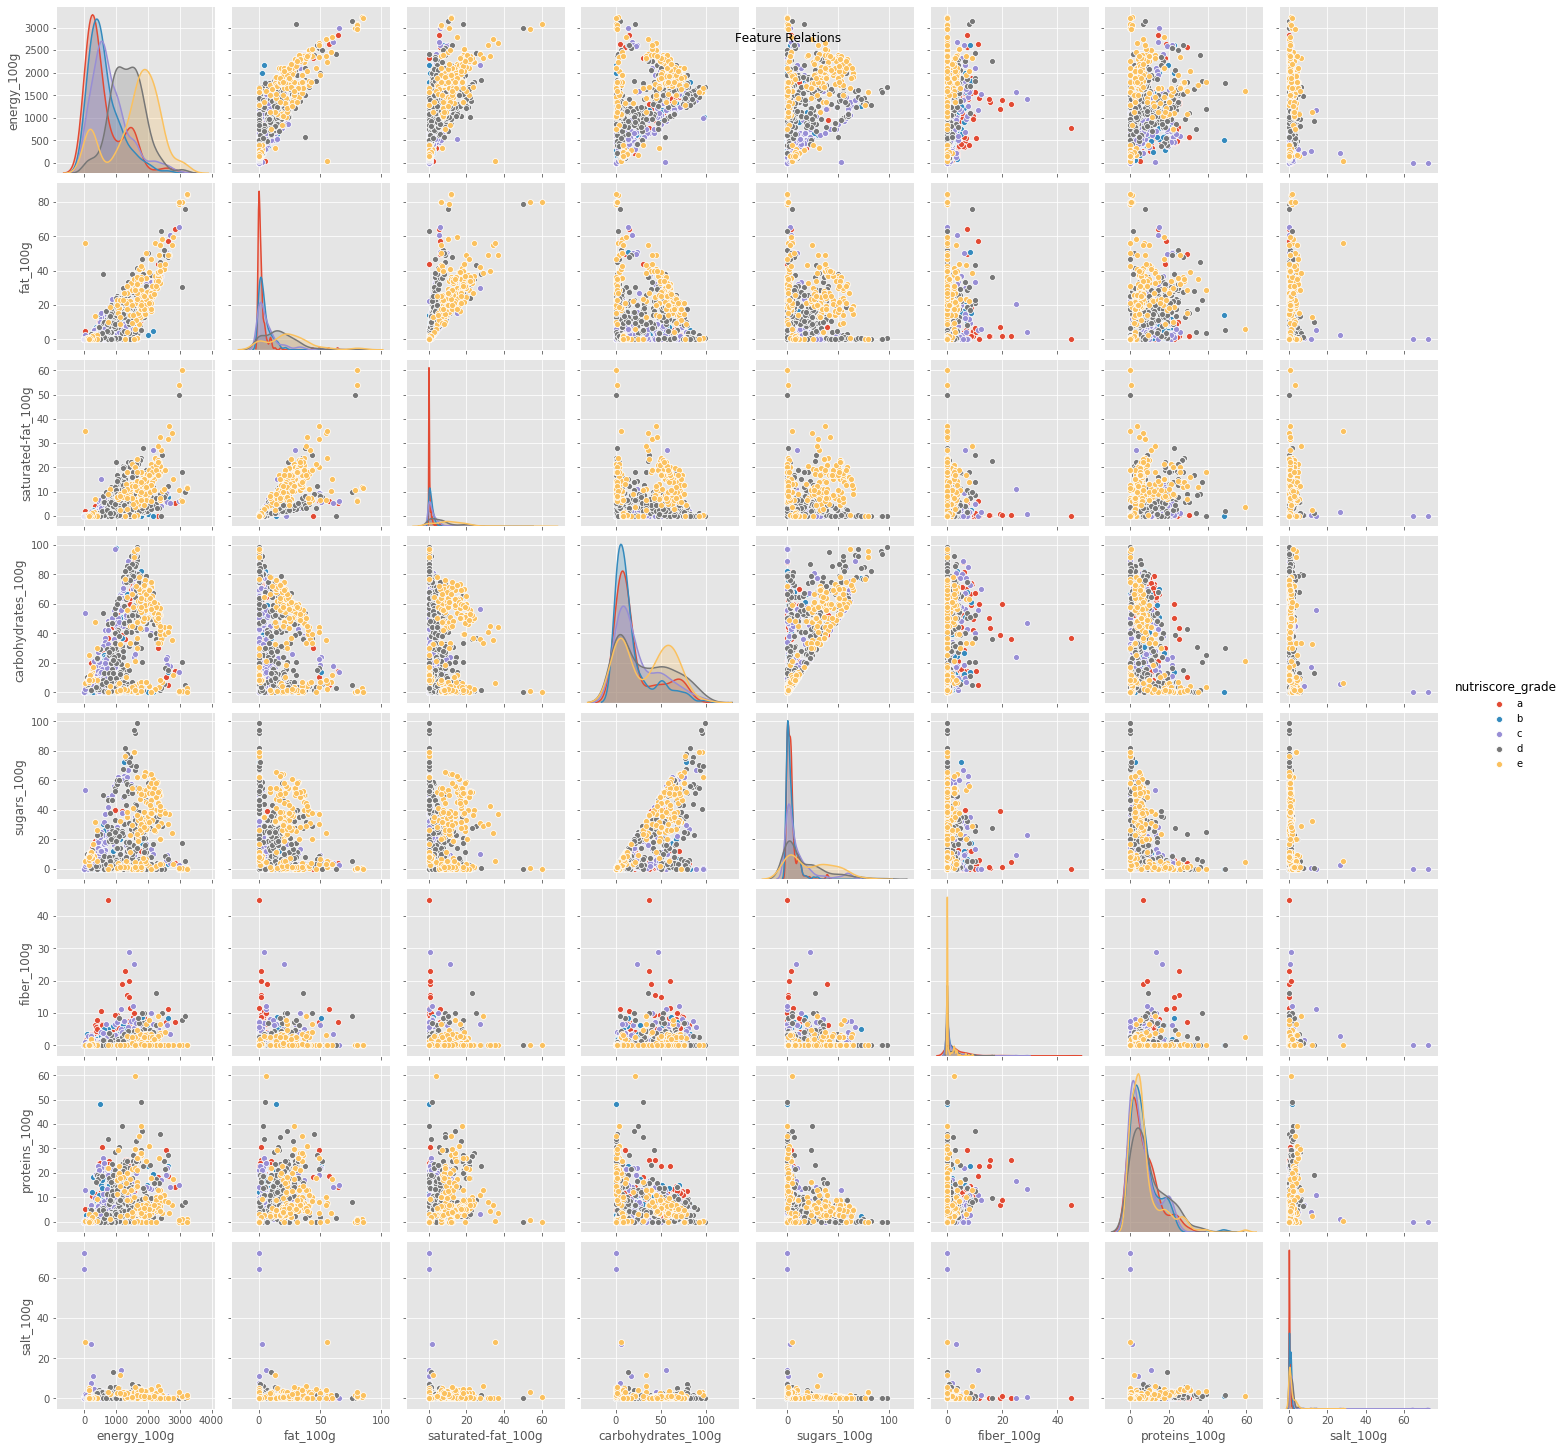

In [94]:
index = np.random.permutation(df.index)[0:2000]

g = sns.pairplot(data=df.loc[index], vars=["energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g" ,"fiber_100g", "proteins_100g", "salt_100g"], hue = "nutriscore_grade")
g.fig.suptitle('Feature Relations')
plt.show()

## 3. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform 'nutriscore_grade' column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating nutriscore_grade column, where it will be used as labels.
3. We will try different splits of our dataset (with/without feature selection, with/without feature scaling.

##### nutriscore_grade Transform


In [150]:
df_final = df[["product_name", "nutriscore_grade", "energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]]


In [151]:
df_final.head()

,product_name,nutriscore_grade,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,vitória crackers,NaN,1569.0,7.0,3.08,70.1,15.0,0.0,7.8,1.40
1,moutarde au moût de raisin,d,936.0,8.2,2.20,29.0,22.0,0.0,5.1,4.60
2,sauce sweety chili 0%,NaN,88.0,0.0,0.00,4.8,0.4,0.0,0.2,2.04
3,mini coco,NaN,251.0,3.0,1.00,10.0,3.0,0.0,2.0,1.15
4,salade de carottes râpées,b,134.0,0.3,0.10,5.3,3.9,0.0,0.9,0.42


##### Data Split 1: all of our final dataset, no scaling

In [152]:
y = df_final['nutriscore_grade'].dropna()
X = df_final.dropna(subset = ["nutriscore_grade"]).drop(['nutriscore_grade','product_name'], axis=1)

encoder = LabelEncoder()
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

##### Data Split 2: all of our final dataset,  scaling

In [153]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

## 4. Modelization
### 4.1 K-NN
##### Model Training

In [154]:
accuracy = {}

In [155]:
knn_clf = KNeighborsClassifier()

accuracy["knn"] = cross_val_score(knn_clf, X_train, y_train, cv=10)

print("Accuracy for a k-NN on validation dataset : {:.2f} %".format(100*accuracy["knn"].mean()))

Accuracy for a k-NN on validation dataset : 76.55 %


In [154]:
accuracy = {}

In [156]:
knn_clf2 = KNeighborsClassifier()

accuracy["knn"] = cross_val_score(knn_clf, X2_train, y2_train, cv=10)

print("Accuracy for a k-NN on validation dataset : {:.2f} %".format(100*accuracy["knn"].mean()))

Accuracy for a k-NN on validation dataset : 86.94 %
